In [2]:
!pip install tld requests requests-cache dateparser
import requests
import requests_cache

requests_cache.install_cache('demo_cache')

You should consider upgrading via the '/Users/epicfaace/.pyenv/versions/3.9.0/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
TOTAL_NUM = 30000

!wget https://worksheets.codalab.org/rest/bundles/0xe87bfb1153764258b049554ef57b3d46/contents/blob/output.json -O src/output.json

--2020-11-15 18:08:00--  https://worksheets.codalab.org/rest/bundles/0xe87bfb1153764258b049554ef57b3d46/contents/blob/output.json
Resolving worksheets.codalab.org (worksheets.codalab.org)... 40.114.41.203
Connecting to worksheets.codalab.org (worksheets.codalab.org)|40.114.41.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [application/json]
Saving to: ‘src/output.json’

src/output.json         [  <=>               ]   4.37M  12.3MB/s    in 0.4s    

2020-11-15 18:08:00 (12.3 MB/s) - ‘src/output.json’ saved [4586068]



In [4]:
import json
from collections import defaultdict
with open("src/output.json") as f:
    domains = json.load(f)

domains_none_detected = len([d for d in domains if len(d["output"]) == 0])
domains_detected = len([d for d in domains if len(d["output"])])
packages = defaultdict(lambda: defaultdict(int))
package_totals = defaultdict(int)
for domain in domains:
    for package in domain["output"]:
        package_details = domain["output"][package]
        version = package_details.get("version", "N/A")
        packages[package][version] += 1
        package_totals[package] += 1
        
stats = {
    "total_domains": TOTAL_NUM,
    "domains_none_detected": domains_none_detected,
    "domains_detected": domains_detected,
    "domains_failed_connect": TOTAL_NUM - domains_none_detected - domains_detected,
    "package_totals": package_totals,
    "packages": packages
}
# print(stats)

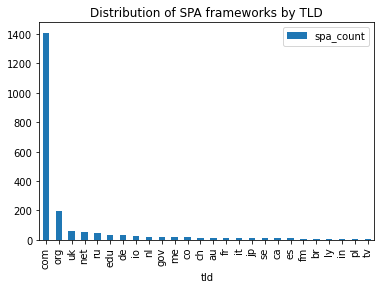

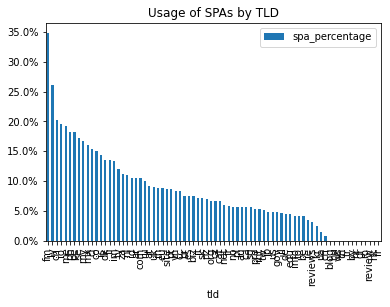

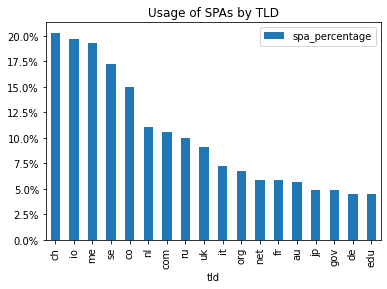

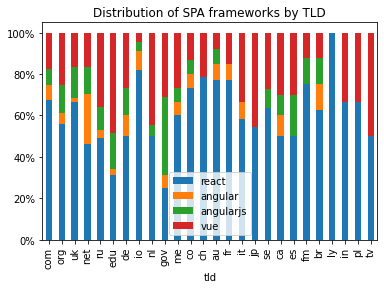

In [25]:
import pandas as pd
import os
import matplotlib.ticker as mtick

def get_tld(domain):
    return domain.split(".")[-1]

OUTPUT_DIR = "src/output"
SPA_PACKAGES = ('react', 'angular', 'angularjs', 'vue')

os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.DataFrame.from_records(domains)
df['packages'] = df['output'].apply(lambda x: x.keys())
df['SPA'] = df['packages'].apply(lambda x: not set(x).isdisjoint(set(SPA_PACKAGES)))
for package in SPA_PACKAGES:
    df[package] = df['packages'].apply(lambda x: package in x)
df['tld'] = df['domain'].apply(lambda x: get_tld(x))

# Group into others
THRESHOLD = 0
grouped_df = df.groupby(['tld']).agg(list).reset_index()
grouped_df['count'] = df['domain'].map(len)
# Group again to get "Other" column
other_tlds = list(grouped_df[grouped_df['count'] < THRESHOLD]['tld'].to_numpy())
# Construct final df and group
df.loc[df.tld.isin(other_tlds), 'tld'] = 'Other'
df['spa'] = df['react'] + df['angular'] + df['angularjs'] + df['vue']
df = df.groupby(['tld']).agg(list).reset_index()
df['count'] = df['domain'].map(len)

for package in SPA_PACKAGES:
    df[package] = df[package].apply(lambda x: len([i for i in x if i == True]))
df['spa_count'] = df['react'] + df['angular'] + df['angularjs'] + df['vue']
df['spa_percentage'] = df['spa'].apply(lambda x: len([i for i in x if i == True])) / df['count'] * 100

# non-percentage chart
df_ = df[df['spa_count'] > 5]
df_ = df_.sort_values(['spa_count'], ascending=False)
ax = df_.plot.bar(x='tld', y=['spa_count'], stacked=True, title="Distribution of SPA frameworks by TLD")
ax.figure.savefig(f'{OUTPUT_DIR}/spa-numbers-by-tld.png', dpi=300, bbox_inches='tight')


# spa % chart
df_ = df[df['count'] > 10][df['spa_percentage'] > 5]
df_ = df_.sort_values(['spa_percentage'], ascending=False)
ax = df_.plot.bar(x='tld', y=['spa_percentage'], stacked=True, title="Usage of SPAs by TLD")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.figure.savefig(f'{OUTPUT_DIR}/spa-percentages-by-tld.png', dpi=300, bbox_inches='tight')


# spa % chart (#2)
df_ = df[df['spa_count'] > 5]
df_ = df_.sort_values(['spa_percentage'], ascending=False)
ax = df_.plot.bar(x='tld', y=['spa_percentage'], stacked=True, title="Usage of SPAs by TLD")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.figure.savefig(f'{OUTPUT_DIR}/spa-percentages-by-tld-2.png', dpi=300, bbox_inches='tight')


# Calculate percentages
for package in SPA_PACKAGES:
    df[package] = df[package] / df['spa_count'] * 100

df_ = df[df['spa_count'] > 5]
df_ = df_.sort_values(['spa_count'], ascending=False)
ax = df_.plot.bar(x='tld', y=['react', 'angular', 'angularjs', 'vue'], stacked=True, title="Distribution of SPA frameworks by TLD")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.figure.savefig(f'{OUTPUT_DIR}/spa-by-tld.png', dpi=300, bbox_inches='tight')

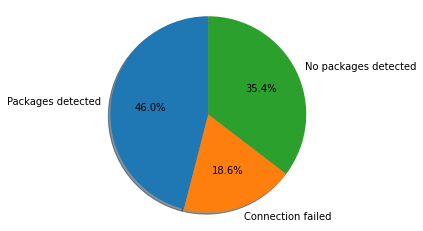

In [6]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Packages detected', 'Connection failed', 'No packages detected'
sizes = [stats["domains_detected"], stats["domains_failed_connect"], stats["domains_none_detected"]]
explode = (0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.savefig(f'{OUTPUT_DIR}/detection.png', dpi=300, bbox_inches='tight')
plt.show()

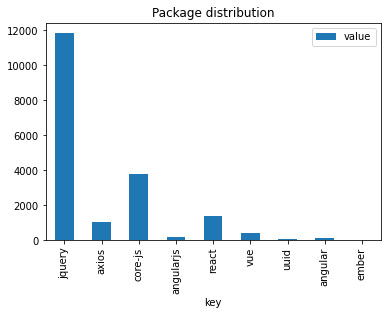

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
package_totals = stats["package_totals"]

df = pd.DataFrame.from_records([{"key": k, "value": v} for k, v in package_totals.items()])

ax = df.plot.bar(x='key', y='value', stacked=True, title="Package distribution")
ax.figure.savefig(f'{OUTPUT_DIR}/package-distributions.png', dpi=300, bbox_inches='tight')

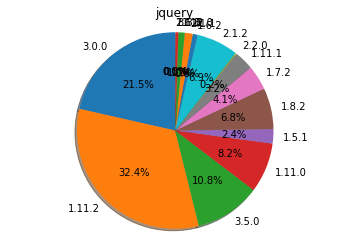

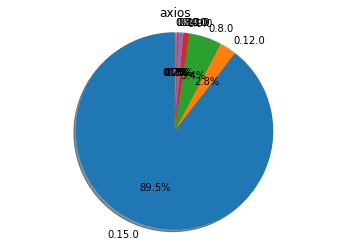

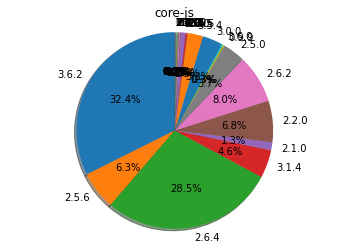

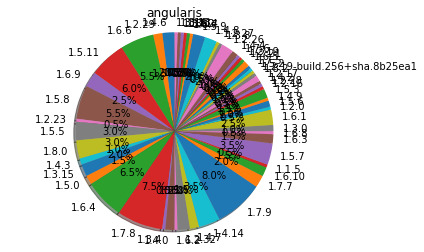

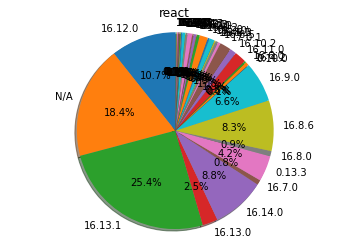

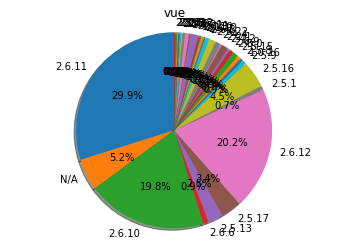

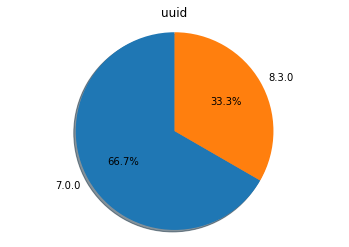

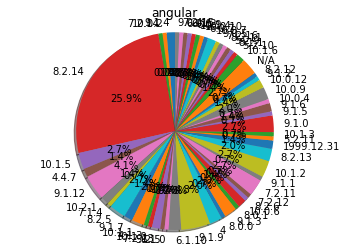

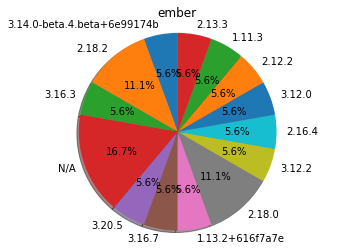

In [8]:
for i, package in enumerate(stats["packages"]):
    labels = stats["packages"][package].keys()
    sizes = stats["packages"][package].values()
    explode = [0 for i in sizes]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.title(package)

    plt.savefig(f'{OUTPUT_DIR}/packages-{package}.png', dpi=300, bbox_inches='tight')
    plt.show()

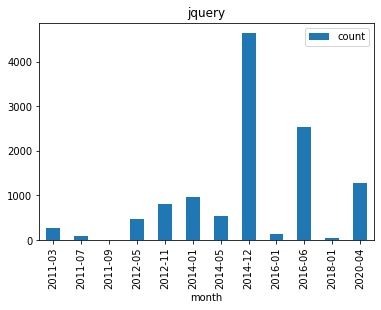

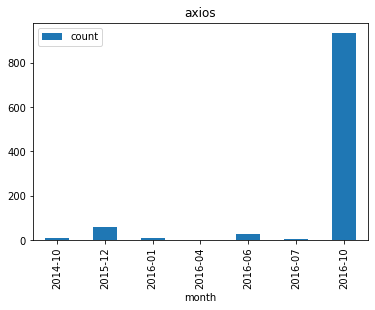

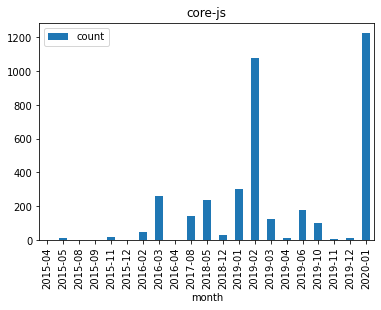

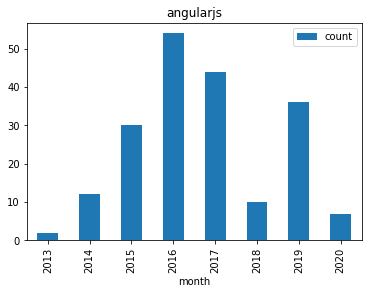

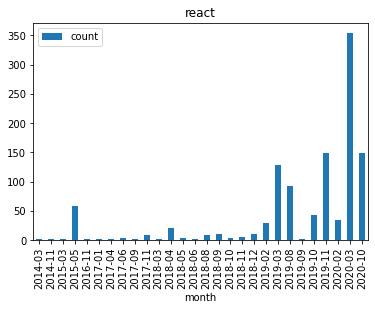

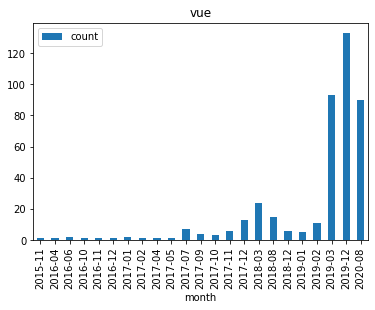

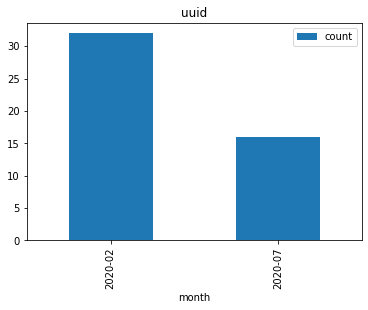

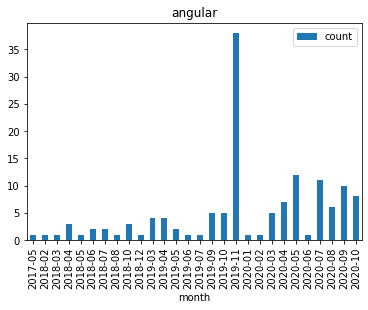

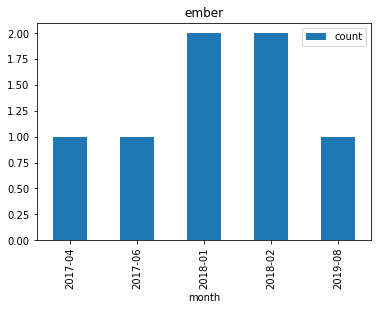

In [11]:
import requests
import dateparser
from datetime import date

def get_npm_name(package):
    if package == "angularjs": return "angular"
    if package == "ember": return "ember-cli"
    if package == "angular": return "%40angular%2Fcore"
    return package

for package in stats["packages"]:
    versions = stats["packages"][package]
    version_times = requests.get(f"https://replicate.npmjs.com/{get_npm_name(package)}").json()["time"]
    data = [{"label": k, "date": version_times[k], "count": v} for k, v in versions.items() if k in version_times]
    df = pd.DataFrame.from_records(data)
    if len(df) == 0: continue
    df["date"] = df["date"].astype("datetime64")
    df["month"] = pd.to_datetime(df.date).dt.to_period("Y" if package == "angularjs" else "M")
    g = df.groupby(["month"]).agg({"count": "sum", "date": "first", "label": "first"})    
    ax = g.plot(kind="bar", y="count", title=package)
    ax.figure.savefig(f'{OUTPUT_DIR}/packages-histogram-{package}.png', dpi=300, bbox_inches='tight')
#     x_labels = df["date"].dt.strftime("%x")
#     ax.set_xticklabels([x.strftime("%x") for x in ax.get_xticklabels()])

In [10]:
print(stats["package_totals"])

# df = pd.DataFrame.from_records(stats["package_totals"])
print(df)

# ax = df.plot.bar(x=['react', 'angular', 'angularjs', 'vue'], y=['count'], stacked=True, title="Distribution of SPA frameworks by TLD")


defaultdict(<class 'int'>, {'jquery': 11827, 'axios': 1045, 'core-js': 3787, 'angularjs': 200, 'react': 1394, 'vue': 445, 'uuid': 48, 'angular': 147, 'ember': 18})
    label                    date  count    month
0  2.18.2 2018-02-02 10:43:30.517      2  2018-02
1  2.18.0 2018-01-01 18:46:05.184      2  2018-01
2  3.12.0 2019-08-16 08:57:24.439      1  2019-08
3  2.12.2 2017-04-22 12:27:37.670      1  2017-04
4  2.13.3 2017-06-25 20:04:59.583      1  2017-06
